<a href="https://colab.research.google.com/github/gaixen/BCS_recruitment/blob/main/Are%20You%20Bored%20Yet%3F/demo_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation and configuration of dependencies

In [68]:
!pip install --quiet ONE-api
!pip install --quiet ibllib

In [69]:
from one.api import ONE
import numpy as np
import pandas as pd
ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')

Connected to https://openalyx.internationalbrainlab.org as user "intbrainlab"


# Loading trials data for a single subject

In [70]:
datasets = one.alyx.rest('datasets', 'list', tag='2021_Q1_IBL_et_al_Behaviour', name='_ibl_subjectTrials.table.pqt')
subjects = np.unique([d['file_records'][0]['relative_path'].split('/')[2] for d in datasets])
#Load in the subjectTrials table and sessionTrials table for the first subject
subject = subjects[0]
subject_trials = one.load_aggregate('subjects', subject, '_ibl_subjectTrials.table')
session_trials = one.load_aggregate('subjects', subject, '_ibl_subjectSessions.table')
#Add in lab, task_protocol, subject name information from the sessions table
if 'task_protocol' in subject_trials:
    subject_trials = subject_trials.drop('task_protocol', axis=1)
subject_trials = subject_trials.set_index('session').join(session_trials.drop('date', axis=1))

The `subject_trials` table contains all the trials data for each training session collected in the subject. See [here](https://www.google.com/url?q=https%3A%2F%2Fdocs.google.com%2Fdocument%2Fd%2F1OqIqqakPakHXRAwceYLwFY9gOrm8_P62XIfCTnHwstg%2Fedit%23heading%3Dh.ls81qq9ihg4x) for more information about this dataset.

In [71]:
# Find the number of sessions for this subject
n_sessions = subject_trials.index.unique().size
print(f'Subject {subject} has {n_sessions} sessions')
# Find the number of times a task protocol was run
n_protocols = subject_trials[~subject_trials.index.duplicated()].task_protocol.value_counts()
print(n_protocols)

Subject CSHL045 has 76 sessions
task_protocol
_iblrig_tasks_biasedChoiceWorld6.3.1      17
_iblrig_tasks_trainingChoiceWorld6.1.3    14
_iblrig_tasks_trainingChoiceWorld6.2.5    12
_iblrig_tasks_trainingChoiceWorld6.3.1    11
_iblrig_tasks_biasedChoiceWorld6.2.5       6
_iblrig_tasks_ephysChoiceWorld6.2.5        3
_iblrig_tasks_trainingChoiceWorld6.2.4     3
_iblrig_tasks_trainingChoiceWorld6.0.6     3
_iblrig_tasks_trainingChoiceWorld6.2.1     2
_iblrig_tasks_ephysChoiceWorld6.4.0        2
_iblrig_tasks_trainingChoiceWorld6.2.0     1
_iblrig_tasks_trainingChoiceWorld6.1.1     1
_iblrig_tasks_trainingChoiceWorld6.1.2     1
Name: count, dtype: int64


We can get the trials data for an individual session of choice, here a the first session using the `biasedChoiceWorld` protocol

In [72]:
# Get the trials data for a single session
# Find a session run under biasedChoiceWorld
sess = subject_trials[subject_trials['task_protocol'].str.contains('biasedChoiceWorld')].index.unique()[0]
trials = subject_trials[subject_trials.index == sess]

In [73]:
print(session_trials.columns)

Index(['lab', 'subject', 'date', 'number', 'task_protocol', 'projects'], dtype='object')


In [74]:
#get all known subjects
subjects = one.alyx.rest('subjects', 'list')
#loop to find a subject with biasedChoiceWorld sessions
valid_subject = None
valid_eids = None
# subjects_df=pd.DataFrame()
for s in subjects:
    nickname = s['nickname']
    try:
        eids = one.search(subject=nickname, task_protocol='biasedChoiceWorld')
        if len(eids) > 0:
            valid_subject = nickname
            valid_eids = eids
            # subjects_df=subjects_df.append({'subject': nickname}, ignore_index=True)
            # subjects_df=subjects_df.append({'subject':len(eids)},ignore_index=True)
            print(f"available subject:{nickname} with {len(eids)} biasedChoiceWorld session(s)")
            break  # stop after finding one valid subject
    except:
        continue  # skip if there's a network or data error
#combining them in a table

available subject:CSHL_001 with 12 biasedChoiceWorld session(s)


In [75]:
if valid_eids:
    eid = valid_eids[0]
# Load trial data
trials = one.load_object(eid, 'trials')
# Show available trial data keys
print("trial data keys:", trials.keys())


trial data keys: dict_keys(['feedbackType', 'contrastRight', 'choice', 'probabilityLeft', 'rewardVolume', 'goCue_times', 'stimOn_times', 'feedback_times', 'response_times', 'firstMovement_times', 'contrastLeft', 'intervals'])


# Creating a DataFrame

In [76]:
trials_1d = {k: v for k, v in trials.items() if isinstance(v, (list, np.ndarray)) and np.array(v).ndim == 1}
#convert trials_1d to dataframe
df = pd.DataFrame(trials_1d)
df['session_id'] = eid
#show first few rows
df.head()

,feedbackType,contrastRight,choice,probabilityLeft,rewardVolume,goCue_times,stimOn_times,feedback_times,response_times,firstMovement_times,contrastLeft,session_id
0,-1.0,NaN,-1.0,0.5,0.0,1.6922,NaN,NaN,16.3270,NaN,0.0625,81f9aa32-c0a0-489d-8a3f-d5cf8a94b777
1,-1.0,0.25,1.0,0.5,0.0,20.0662,NaN,NaN,35.9022,NaN,NaN,81f9aa32-c0a0-489d-8a3f-d5cf8a94b777
2,-1.0,0.00,1.0,0.5,0.0,39.7385,NaN,NaN,47.0627,NaN,NaN,81f9aa32-c0a0-489d-8a3f-d5cf8a94b777
3,-1.0,NaN,-1.0,0.5,0.0,50.5550,NaN,NaN,50.8648,NaN,0.0625,81f9aa32-c0a0-489d-8a3f-d5cf8a94b777
4,1.0,NaN,1.0,0.5,1.5,54.3064,NaN,70.1632,70.1632,69.7623,0.1250,81f9aa32-c0a0-489d-8a3f-d5cf8a94b777


Adding on important parameters that reflect upon the boredom of subject(CSHL_001)over experiment time...

In [77]:
df['reaction_time']=df['response_times']-df['goCue_times']
df['skipped']=df['reaction_time'].isna()
df['correct'] = (df['feedbackType'] == 1).astype(int)
df['MA_reaction_time']=df['correct'].rolling(window=10, min_periods=1).mean()
choice_map = {1: 1, 0: 0.5, -1: 0}
df['choice_mapped'] = df['choice'].map(choice_map)
df['rolling_choice_bias'] = df['choice_mapped'].rolling(window=10, min_periods=1).mean()
df['reaction_time_smoothed'] = df.groupby('session_id')['reaction_time'].transform(
    lambda x: x.rolling(window=10, min_periods=1).mean()
)
df['skip_rate_smoothed'] = df.groupby('session_id')['skipped'].transform(
    lambda x: x.rolling(window=10, min_periods=1).mean()
)
df['skip_rate_smoothed'] = df['skip_rate_smoothed'].astype(int)
df['rolling_accuracy'] = df.groupby('session_id')['correct'].transform(
    lambda x: x.rolling(window=10, min_periods=1).mean()
)

#df['trial_block'] = df['trial_num'] // 50
if 'intervals' in trials and np.array(trials['intervals']).ndim == 2:
    intervals = trials['intervals']
    df['intervals'] = list(intervals)
    df['trial_start'] = intervals[:, 0]
    df['trial_end'] = intervals[:, 1]
    df['trial_duration'] = trials['intervals'][:, 1] - trials['intervals'][:, 0]
else:
    print("data not available")
df['inter_trial_interval'] = df.groupby('session_id')['intervals'].transform(
    lambda x: np.insert(np.diff([i[0] for i in x]), 0, np.nan)
)
df.drop(columns=['choice_mapped'], inplace=True)
df['inter_trial_interval'][0]=df['inter_trial_interval'].mean()

<ipython-input-77-10706ed38177>:32: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['inter_trial_interval'][0]=df['inter_trial_interval'].mean()
<ipython-input-77-10706ed38177>:32: SettingWithCopyWarning: 
A value is trying to be set on a c

In [78]:
df.head()

,feedbackType,contrastRight,choice,probabilityLeft,rewardVolume,goCue_times,stimOn_times,feedback_times,response_times,firstMovement_times,...,MA_reaction_time,rolling_choice_bias,reaction_time_smoothed,skip_rate_smoothed,rolling_accuracy,intervals,trial_start,trial_end,trial_duration,inter_trial_interval
0,-1.0,NaN,-1.0,0.5,0.0,1.6922,NaN,NaN,16.3270,NaN,...,0.0,0.000000,14.634800,0,0.0,"[0.0, 18.827002]",0.0000,18.827002,18.827002,6.085565
1,-1.0,0.25,1.0,0.5,0.0,20.0662,NaN,NaN,35.9022,NaN,...,0.0,0.500000,15.235400,0,0.0,"[19.3521, 38.402203]",19.3521,38.402203,19.050103,19.352100
2,-1.0,0.00,1.0,0.5,0.0,39.7385,NaN,NaN,47.0627,NaN,...,0.0,0.666667,12.598333,0,0.0,"[38.9466, 49.562701999999994]",38.9466,49.562702,10.616102,19.594500
3,-1.0,NaN,-1.0,0.5,0.0,50.5550,NaN,NaN,50.8648,NaN,...,0.0,0.500000,9.526200,0,0.0,"[50.0203, 53.364802]",50.0203,53.364802,3.344502,11.073700
4,1.0,NaN,1.0,0.5,1.5,54.3064,NaN,70.1632,70.1632,69.7623,...,0.2,0.600000,10.792320,0,0.2,"[53.7649, 71.663202]",53.7649,71.663202,17.898302,3.744600


In [79]:
df['skip_rate_smoothed'].head(40)

,skip_rate_smoothed
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


# Model Optimization

**Hypertuning the parameters**


---





In [80]:
w1=1.0 #more than 0
w2=1.0 #more than 0
w3=1.0 #more than 0
w4=1.0 #more than 0
w5=1.0 #more than 0

Calculating Boredom Scores

---



In [67]:
df['boredom_score'] = (w1*df['reaction_time_smoothed'] +w2*(1 - df['rolling_accuracy']) + w3*df['trial_duration']+w4*df['skip_rate_smoothed'])
df['boredom_score'].head()

,boredom_score
0,34.461802
1,35.285503
2,24.214435
3,13.870702
4,29.490622


Attempt to make it continuous

---



In [81]:
from sklearn.preprocessing import MinMaxScaler

# List of features to include
features = ['reaction_time_smoothed','skip_rate_smoothed','trial_duration']

# Invert rolling_accuracy since low accuracy = high boredom
df['inaccuracy'] = 1 - df['rolling_accuracy']

# Optional: Replace inf/nan with 0 for safe scaling
df[features + ['inaccuracy']] = df[features + ['inaccuracy']].replace([np.inf, -np.inf], np.nan).fillna(0)

# Normalize each session separately
df_norm = df.copy()
for session_id in df['session_id'].unique():
    session_mask = df['session_id'] == session_id
    scaler = MinMaxScaler()
    df_norm.loc[session_mask, ['reaction_time_smoothed', 'skip_rate_smoothed',
                                   'trial_duration', 'inaccuracy']] = scaler.fit_transform(
        df.loc[session_mask, ['reaction_time_smoothed', 'skip_rate_smoothed','trial_duration','inaccuracy']]
    )

In [83]:
df_norm['boredom_score'] = (0.35 * df_norm['reaction_time_smoothed'] +0.15 * df_norm['skip_rate_smoothed'] +0.25 * df_norm['trial_duration']+0.25 * df_norm['inaccuracy'])

In [87]:
df_norm['boredom_score_smoothed'] = df_norm.groupby('session_id')['boredom_score'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())
df_norm['trial_num'] = df_norm.groupby('session_id').cumcount()

In [97]:
df_norm.head()

,feedbackType,contrastRight,choice,probabilityLeft,rewardVolume,goCue_times,stimOn_times,feedback_times,response_times,firstMovement_times,...,rolling_accuracy,intervals,trial_start,trial_end,trial_duration,inter_trial_interval,inaccuracy,boredom_score,boredom_score_smoothed,trial_num
0,-1.0,NaN,-1.0,0.5,0.0,1.6922,NaN,NaN,16.3270,NaN,...,0.0,"[0.0, 18.827002]",0.0000,18.827002,0.270123,6.085565,1.0,0.528520,0.528520,0
1,-1.0,0.25,1.0,0.5,0.0,20.0662,NaN,NaN,35.9022,NaN,...,0.0,"[19.3521, 38.402203]",19.3521,38.402203,0.273721,19.352100,1.0,0.538175,0.533348,1
2,-1.0,0.00,1.0,0.5,0.0,39.7385,NaN,NaN,47.0627,NaN,...,0.0,"[38.9466, 49.562701999999994]",38.9466,49.562702,0.137704,19.594500,1.0,0.465726,0.510807,2
3,-1.0,NaN,-1.0,0.5,0.0,50.5550,NaN,NaN,50.8648,NaN,...,0.0,"[50.0203, 53.364802]",50.0203,53.364802,0.020433,11.073700,1.0,0.391621,0.481011,3
4,1.0,NaN,1.0,0.5,1.5,54.3064,NaN,70.1632,70.1632,69.7623,...,0.2,"[53.7649, 71.663202]",53.7649,71.663202,0.255146,3.744600,0.8,0.418757,0.468560,4


***Creating a plot of continuous boredom score***

---



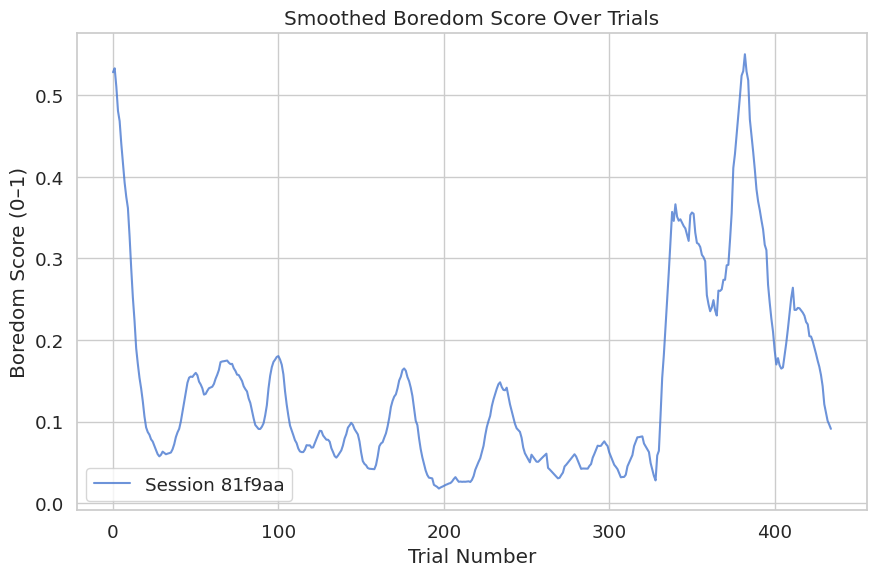

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
# Pick a few sessions to plot
sample_sessions = df_norm['session_id'].unique()[:3]
# Set the style
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
# Plot each session's boredom score over trial number
plt.figure(figsize=(9,6))
for session_id in sample_sessions:
    session_df = df_norm[df_norm['session_id'] == session_id]
    plt.plot(session_df['trial_num'], session_df['boredom_score_smoothed'], label=f"Session {str(session_id)[:6]}", alpha=0.8)
plt.title("Smoothed Boredom Score Over Trials")
plt.xlabel("Trial Number")
plt.ylabel("Boredom Score (0–1)")
plt.legend()
plt.tight_layout()
plt.show()

# **Training a prediction model**

In [104]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [95]:
#features to use
feature_cols = ['reaction_time_smoothed','rolling_accuracy','skip_rate_smoothed','trial_duration']
target_col = 'boredom_score'

In [100]:
# Split trials randomly within the session (less ideal for generalization)
X = df_norm[feature_cols]
y = df_norm[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [101]:
# Train
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [105]:
# Predict
y_pred = rf.predict(X_test)
# Metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

R² Score: 0.977
RMSE: 0.019


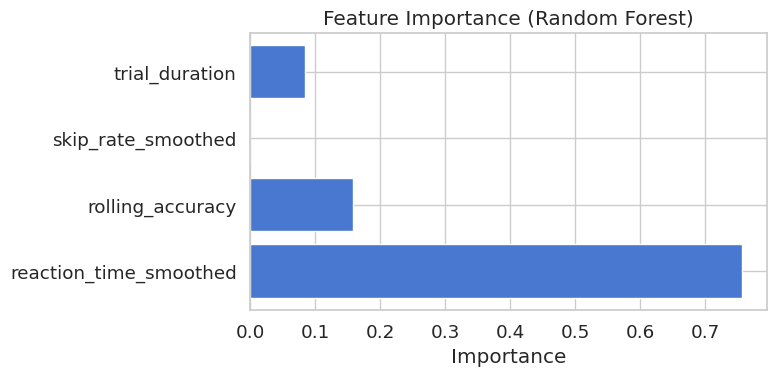

In [103]:
importances = rf.feature_importances_
plt.figure(figsize=(8, 4))
plt.barh(feature_cols, importances)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


# Necessary Plots

Using this data we can plot the psychometric curve and compute some performance metrics, for example the number of trials in the session or the performance of the mouse on easy trials (50% and 100% contrast)

/usr/local/lib/python3.11/dist-packages/brainbox/behavior/training.py:561: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.sum(trials['feedbackType'][easy_trials] == 1) / easy_trials.shape[0]


Number of trials for session a4f7079b-d157-4de9-ba80-de9a98f35c8b: 682
Performance easy for session a4f7079b-d157-4de9-ba80-de9a98f35c8b: 0.9457364341085271


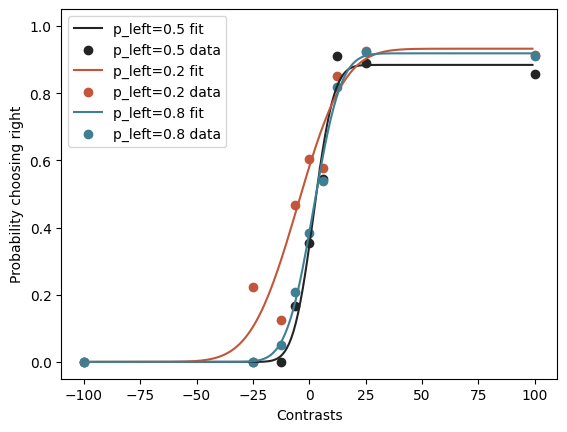

In [6]:
from brainbox.behavior.training import plot_psychometric, compute_n_trials, compute_performance_easy, compute_performance

plot_psychometric(trials)
n_trials = compute_n_trials(trials)
perf_easy = compute_performance_easy(trials)
print(f'Number of trials for session {sess}: {n_trials}')
print(f'Performance easy for session {sess}: {perf_easy}')